In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

raw_loans = pd.read_csv('loan.csv', dtype={47: str}, low_memory=False)

# Use Seaborn's aesthetic
sns.set_theme()

# number of columns and rows
print("Number of columns: ", len(raw_loans.columns))
print("Number of rows: ", len(raw_loans))

Number of columns:  111
Number of rows:  39717


#### Remove unnecessary rows
- Remove loans that are still in progress

In [2]:
# remove loans that are still in progress
loans = raw_loans[raw_loans['loan_status'] != 'Current']

#### Clean up of columns
- Drop columns with all null values
- Drop columns with all same values

In [3]:
# Drop columns with all null values
nan_cols = loans.columns[loans.isna().all()].tolist()
print(len(nan_cols), "collumns have null values in all rows, these columns can be dropped")
loans = loans.drop(nan_cols, axis=1)

# Drop columns with only one unique value
unique_value_cols = loans.columns[loans.nunique() == 1]
print(len(unique_value_cols), "columns have only one unique value, these columns can be dropped as they do not provide any useful information")
loans = loans.drop(unique_value_cols, axis=1)

# Left with columns data
print("\n")
print("Columns left: ", len(loans.columns))

55 collumns have null values in all rows, these columns can be dropped
11 columns have only one unique value, these columns can be dropped as they do not provide any useful information


Columns left:  45


#### Remove outliers
Columns to remove outliers on:
 - loan_amnt
- funded_amnt
- annual_inc

In [4]:
raw_raw_count = len(raw_loans)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    filter = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 *IQR)
    return df.loc[filter]

# remove outliers
loans = remove_outliers(loans, 'loan_amnt')
loans = remove_outliers(loans, 'funded_amnt')
loans = remove_outliers(loans, 'annual_inc')

# calculate percentage of data removed
print("Percentage of data removed: ", round((1 - len(loans)/raw_raw_count) * 100, 2), "%")

Percentage of data removed:  10.11 %


#### Add new columns
- Add column for loan status (0 = not default, 1 = default)
- Add column for loan term (0 = 36 months, 1 = 60 months)
- Add column for loan grade (A-G)
- Add column for loan subgrade (1-5)
- Add column for loan home ownership (1-6)
- Add column for loan verification status (1-3)

- Add column for loan issue month (1-12)
- Add column for loan issue year (2007-2015)

- Add column for loan interest rate (0-30)

- Add column for percent funded (0-100)
- Add column for binning of percent funded (0-100)

- Add column for percent funded by investors (0-100)
- Add column for binning of percent funded by investors (0-100)

In [5]:
# add a new column to indicate if the loan is fully paid or not ( 0 - fully paid, 1 - defaulted)
loans['default'] = np.where(loans['loan_status'].isin(['Fully Paid']), 0, 100)

loans['term_num'] = loans['term'].apply(lambda x: int(x.split()[0]))

# convert issue_d to datetime
loans['issue_d'] = pd.to_datetime(loans['issue_d'], format='%b-%y')
loans['issue_month'] = loans['issue_d'].dt.month
loans['issue_year'] = loans['issue_d'].dt.year

# convert earliest_cr_line to datetime
loans['earliest_cr_line'] = pd.to_datetime(loans['earliest_cr_line'], format='%b-%y')

# convert last_pymnt_d to datetime
loans['last_pymnt_d'] = pd.to_datetime(loans['last_pymnt_d'], format='%b-%y')

# convert last_credit_pull_d to datetime
loans['last_credit_pull_d'] = pd.to_datetime(loans['last_credit_pull_d'], format='%b-%y')

# convert loan grade to numeric
loans['grade_num'] = loans['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

# convert loan sub grade to numeric
loans['sub_grade_num'] = loans['sub_grade'].map({'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
                                                    'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
                                                    'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
                                                    'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
                                                    'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
                                                    'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30,
                                                    'G1': 31, 'G2': 32, 'G3': 33, 'G4': 34, 'G5': 35})

# convert loan sub grade to numeric
loans['emp_length_num'] = loans['emp_length'].map({'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
                                                    '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
                                                    '10+ years': 10})

# convert loan grade and sub grade to combined numeric
loans['grade_sub_grade_num'] = loans['grade_num'] * 100 + loans['sub_grade_num'] * 20

# convert int_rate to numeric
loans['int_rate_num'] = loans['int_rate'].str.rstrip('%').astype('float')


In [6]:
loans = remove_outliers(loans, 'int_rate_num')

## High level information

In [7]:
# average default rate
print("Average default rate: ", (loans['default'].mean()).round(2), "%")

Average default rate:  14.47 %


In [8]:
import numpy_financial as npf

def calc_interest_rate(row):
    return (npf.rate(row['term_num'], row['installment'], -row['funded_amnt'], 0) * 12 * 100).round(2)

loans['total_amount_to_pay'] = loans['installment'] * loans['term_num']
loans['total_interest'] = loans['total_amount_to_pay'] - loans['funded_amnt']
loans['total_loss'] = loans.apply(lambda x: (x['total_pymnt'] - x['total_amount_to_pay']) if x['default'] == 100 else 0, axis=1)
loans['loss_percentage'] = (loans['total_loss'] / loans['total_amount_to_pay'] * 100).abs().round(2)

loans['calc_interest_rate'] = loans.apply(calc_interest_rate, axis=1)

In [9]:
# avg loss percentage for defaulted loans
print("Average loss percentage for defaulted loans: ", (loans['loss_percentage'].mean()).round(2), '%')

print("Total profit: ", -loans['total_loss'].sum())

Average loss percentage for defaulted loans:  8.0 %
Total profit:  41130097.700199


In [10]:
# print rows where calc_interest_rate is not equal to int_rate within 0.1% tolerance
print(loans[(loans['calc_interest_rate'] - loans['int_rate_num']).abs() > 0.1][['int_rate_num', 'calc_interest_rate', 'funded_amnt', 'total_amount_to_pay', 'total_pymnt', 'default']])

       int_rate_num  calc_interest_rate  funded_amnt  total_amount_to_pay  \
2027           6.00                7.54         7000              7843.68   
2708           6.00               14.27        10600             14887.80   
3889          19.91               11.78        15200             20183.40   
10789         16.89               15.28        12000             17233.80   
16951         16.40               10.08        17500             22349.40   
18569         14.91                9.50        20000             25201.20   
21918          6.00               12.87        20000             27225.00   
38340          6.00                7.08         7000              7789.68   
38712          6.00                6.84         7500              8317.08   
39296          6.00                7.62        15000             16828.20   

        total_pymnt  default  
2027    8097.210002        0  
2708   14808.390020        0  
3889   19765.159970        0  
10789  15317.207340        0

In [11]:
# show all columns with null values
print("Columns with null values: ")
print(loans.isnull().sum()[loans.isnull().sum() > 0])
print('\n')
print("Total rows: ", len(loans))
print('\n')

Columns with null values: 
emp_title                  2147
emp_length                  998
desc                      11524
title                        11
mths_since_last_delinq    23022
mths_since_last_record    33030
revol_util                   48
last_pymnt_d                 69
last_credit_pull_d            2
pub_rec_bankruptcies        658
emp_length_num              998
dtype: int64


Total rows:  35645




Number of numerical columns:  39


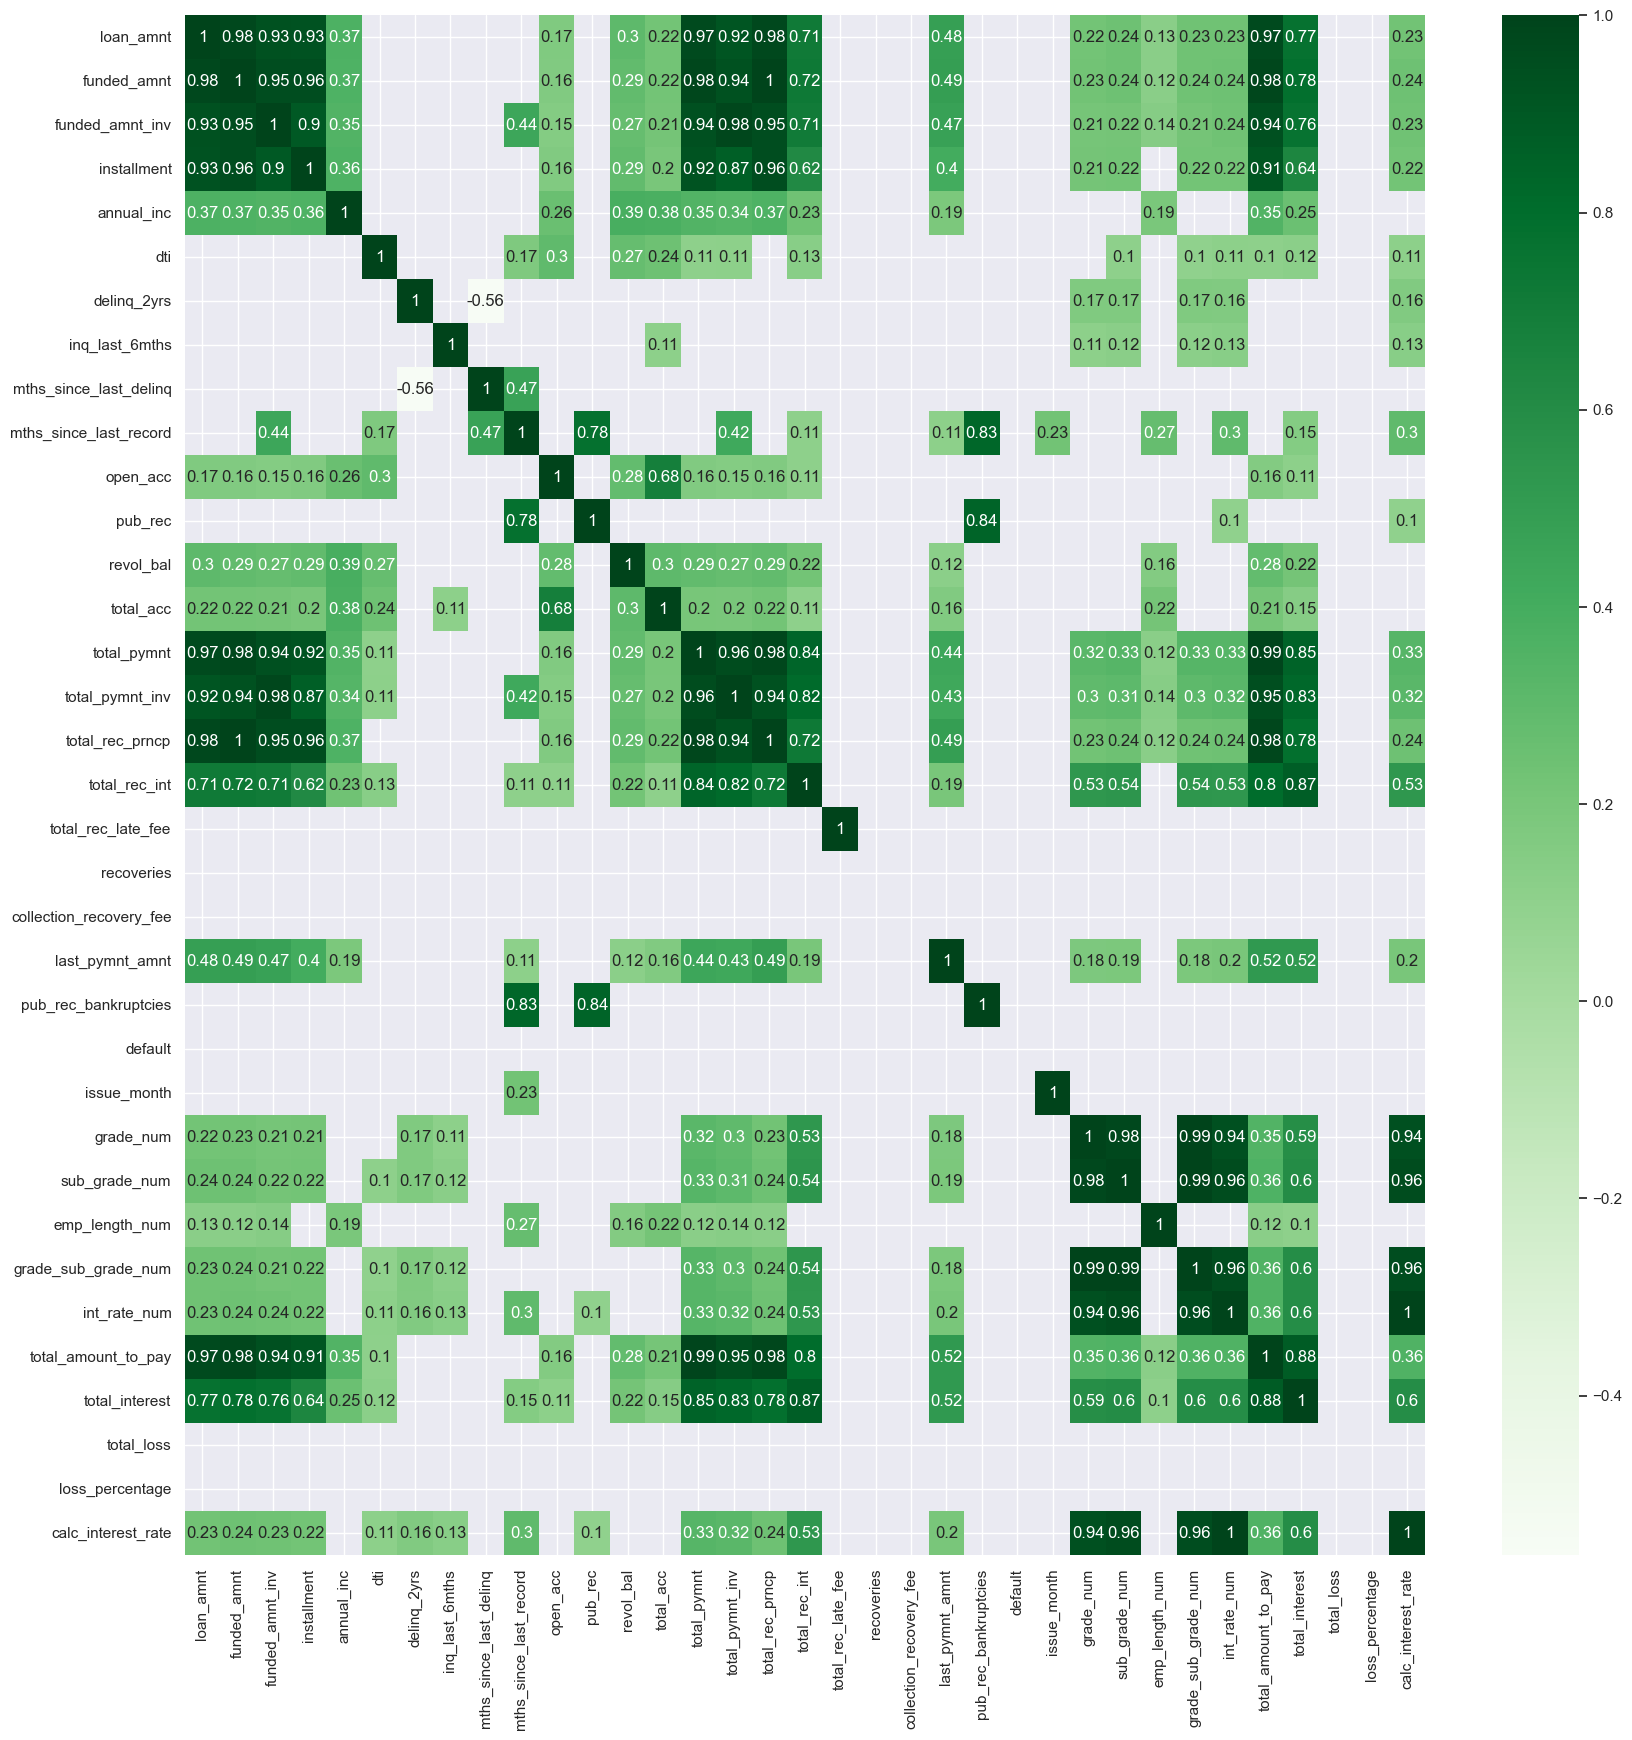

In [12]:
numerical_cols = loans[loans['loan_status'] == 'Fully Paid'].select_dtypes(include=[np.number])
print("Number of numerical columns: ", len(numerical_cols.columns))

cols_to_ignore = ['id', 'member_id', 'term_num', 'issue_year']

numerical_cols.drop(cols_to_ignore, axis=1, inplace=True)

corr_matrix = numerical_cols.corr()
# print(corr_matrix)

# plot correlation matrix
# Replace values below the threshold with NaN
threshold = 0.1
corr_matrix[abs(corr_matrix) < threshold] = np.nan
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Greens)
plt.show()

# Default rate by year and months

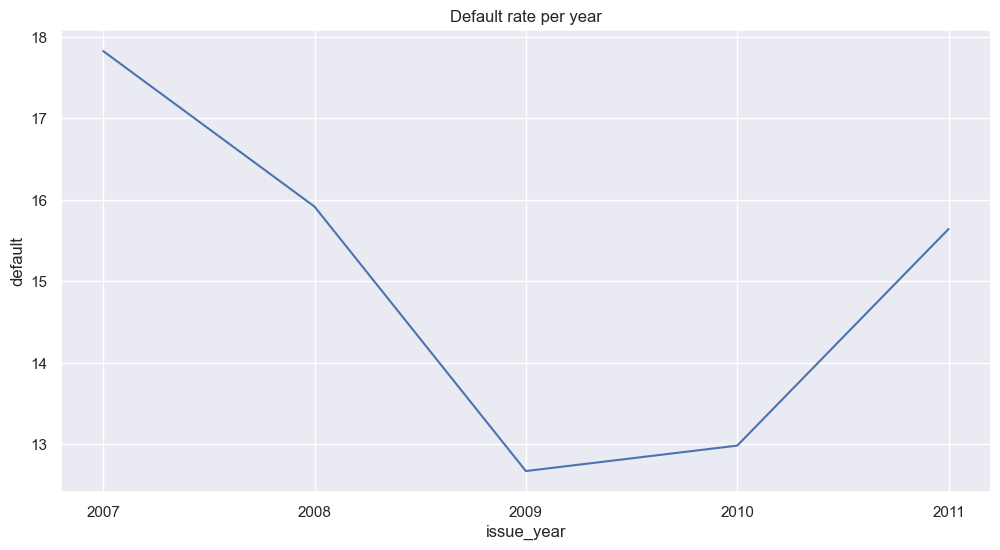

In [13]:
# draw line chart of defaulted loans percentage per year
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_year']).agg({'default': 'mean'}).reset_index()
sns.lineplot(x='issue_year', y='default', data=df)
plt.xticks(df['issue_year'])
plt.title('Default rate per year')
plt.show()

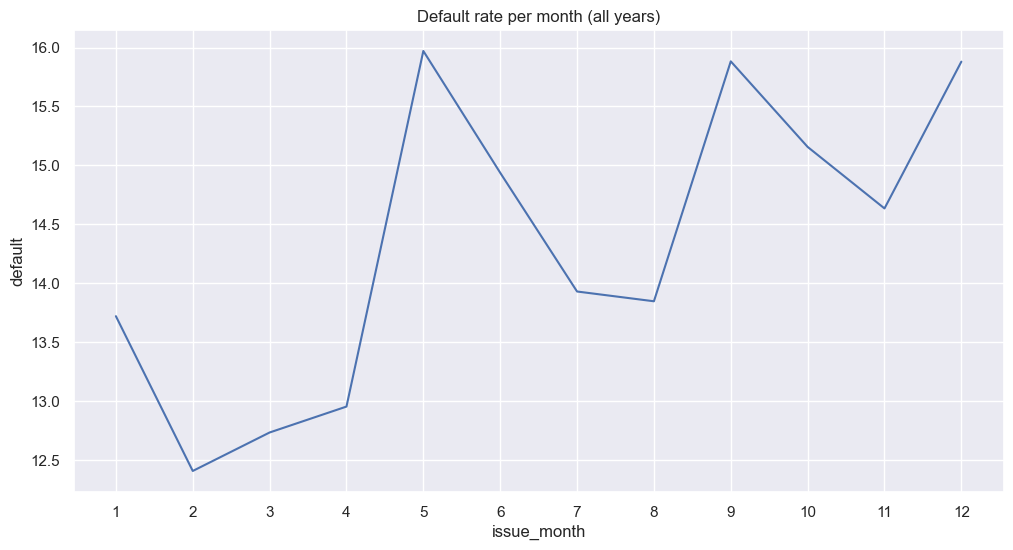

In [14]:
# draw line chart of defaulted loans percentage per month
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_month']).agg({'default': 'mean'}).reset_index()
sns.lineplot(x='issue_month', y='default', data=df)
plt.xticks(df['issue_month'])
plt.title('Default rate per month (all years)')
plt.show()

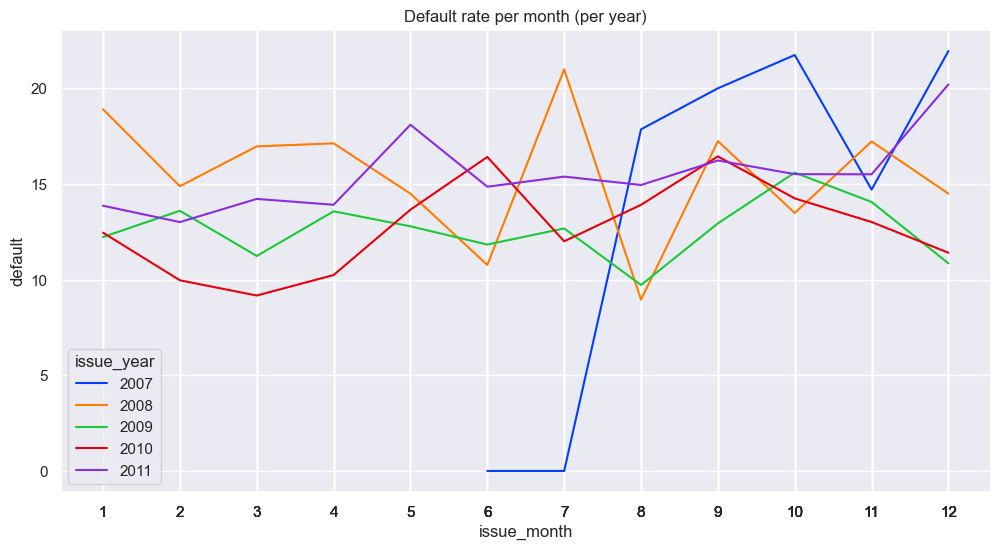

In [15]:
# draw line chart of defaulted loans percentage per month per year
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_year', 'issue_month']).agg({'default': 'mean'}).reset_index()
sns.lineplot(x='issue_month', y='default', hue='issue_year', data=df, palette='bright', legend='full')
plt.xticks(df['issue_month'])
plt.title('Default rate per month (per year)')
plt.show()

# Default rate by grade and subgrade

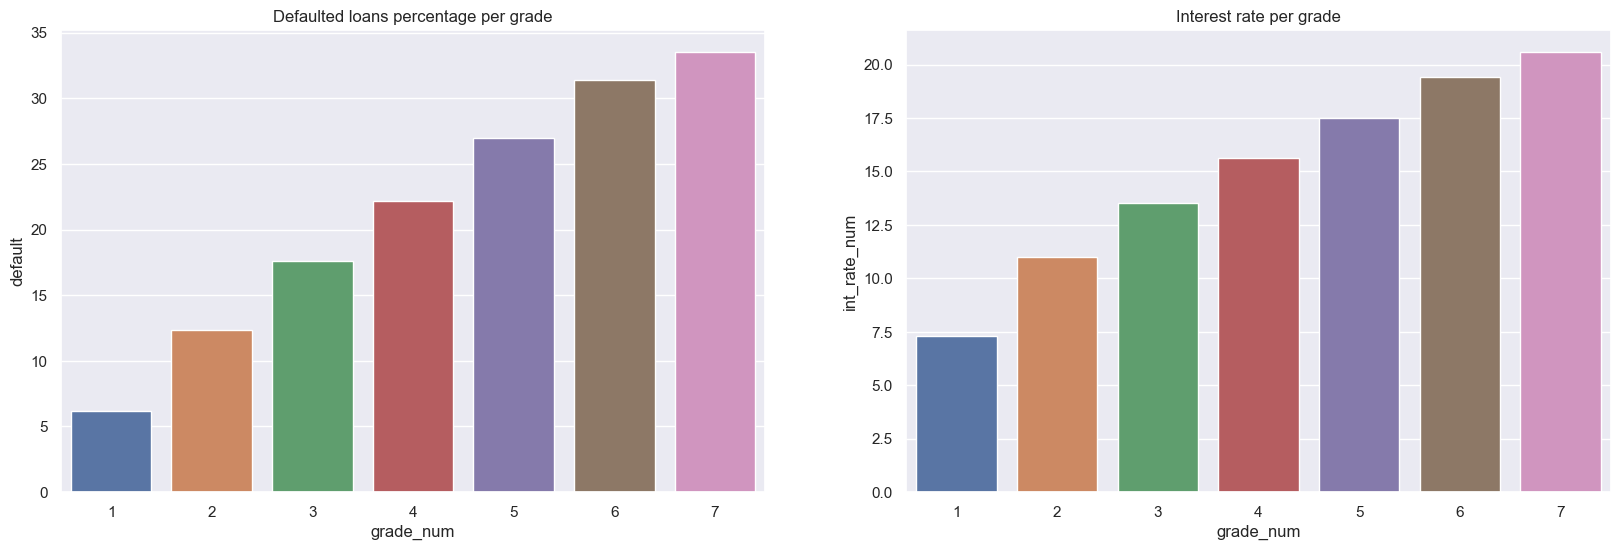

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# draw line chart of defaulted loans percentage per grade
default_rate = loans.groupby(['grade_num']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='grade_num', y='default', data=default_rate, ax=ax1)
ax1.set_title('Defaulted loans percentage per grade')

# draw interest rate per grade
interest_rate = loans.groupby(['grade_num']).agg({'int_rate_num': 'mean'}).reset_index()
sns.barplot(x='grade_num', y='int_rate_num', data=interest_rate, ax=ax2)
ax2.set_title('Interest rate per grade')

plt.show()

# Default rate by term size

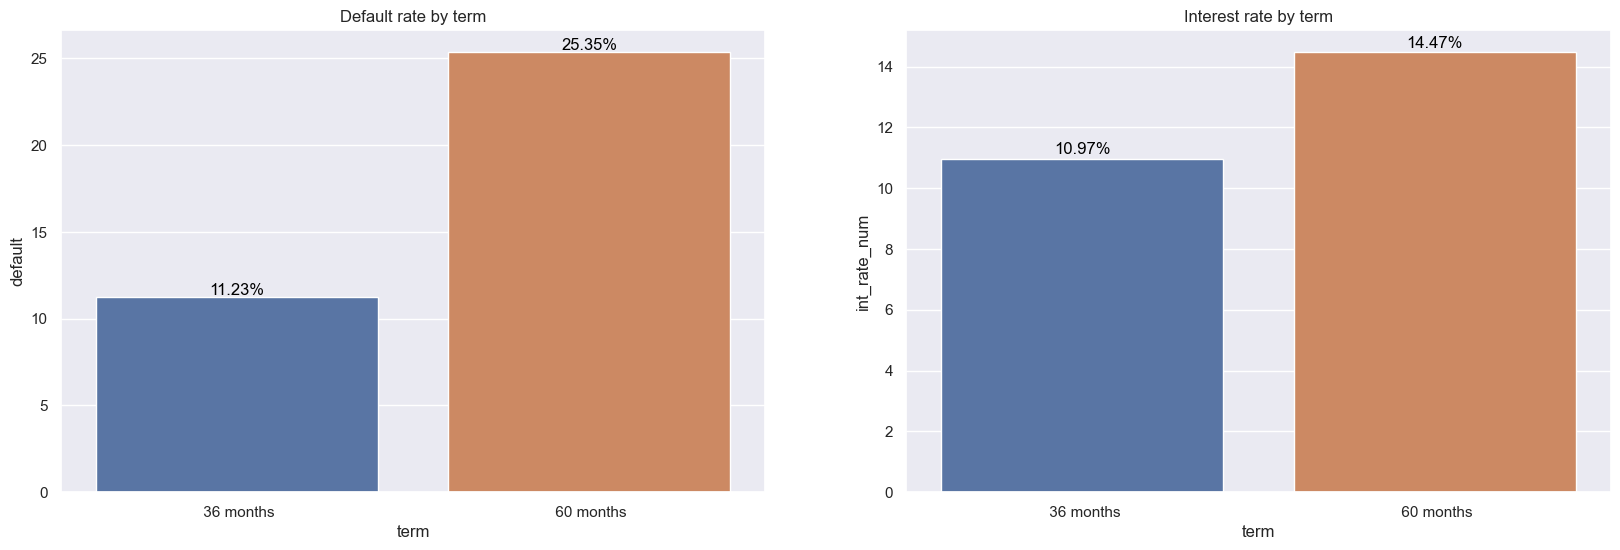

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# plot default rate by term
default_rate = loans.groupby(['term']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='term', y='default', data=default_rate, ax=ax1)

# show values on top of bars
for index, row in default_rate.iterrows():
    ax1.text(row.name, row.default + 0.15, str(round(row.default, 2)) + '%', color='black', ha="center")
ax1.set_title('Default rate by term')

# plot interest rate by term
interest_rate = loans.groupby(['term']).agg({'int_rate_num': 'mean'}).reset_index()
sns.barplot(x='term', y='int_rate_num', data=interest_rate, ax=ax2)

# show values on top of bars
for index, row in interest_rate.iterrows():
    ax2.text(row.name, row.int_rate_num + 0.15, str(round(row.int_rate_num, 2)) + '%', color='black', ha="center")
ax2.set_title('Interest rate by term')

plt.show()

# Default rate by purpose

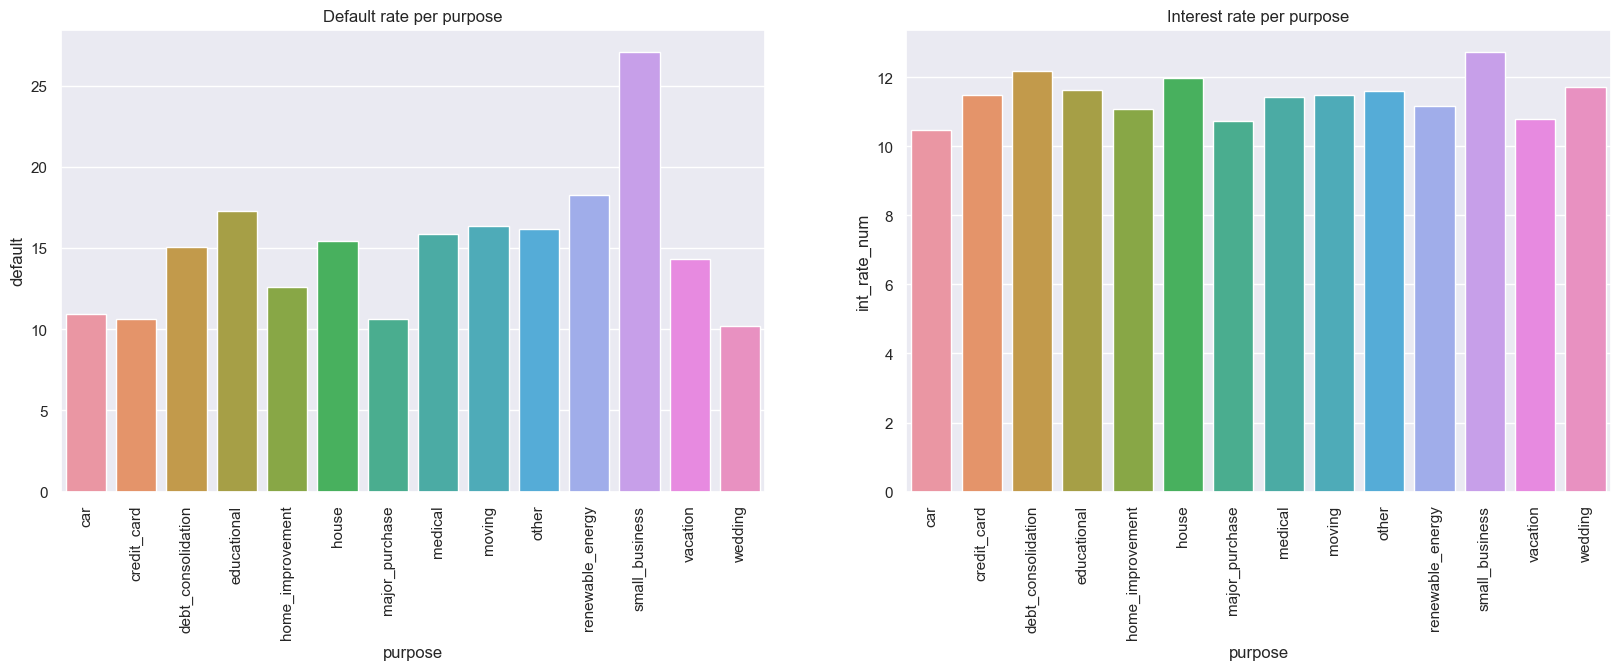

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# draw loan default percentage per purpose
default_rate = loans.groupby(['purpose']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='purpose', y='default', data=default_rate, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Default rate per purpose')

# draw interest rate per purpose
interest_rate = loans.groupby(['purpose']).agg({'int_rate_num': 'mean'}).reset_index()
sns.barplot(x='purpose', y='int_rate_num', data=interest_rate, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title('Interest rate per purpose')

plt.show()

# Default rate by home ownership

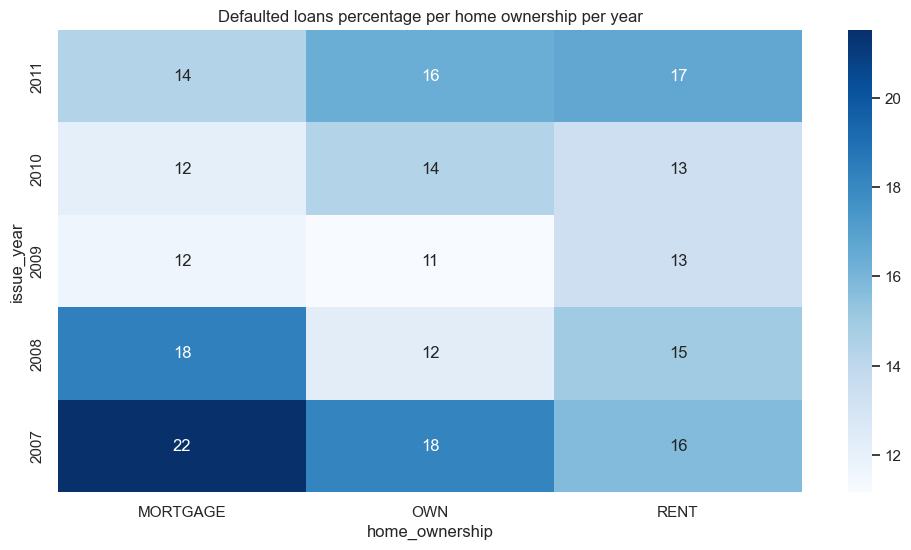

In [19]:
plt.figure(figsize=(12, 6))

df = loans.groupby(['issue_year', 'home_ownership']).agg({'default': 'mean'}).reset_index()

# ignore 'NONE' and 'OTHER' home ownership values as they are too few and do not provide any useful information
df = df[(df['home_ownership'] != 'NONE') & (df['home_ownership'] != 'OTHER')]

df = df.pivot(index='issue_year', columns='home_ownership', values='default')
df = df.sort_index(ascending=False)

sns.heatmap(df, annot=True, cmap='Blues', fmt='.2g')
plt.title('Defaulted loans percentage per home ownership per year')
plt.show()

# Default rate by income

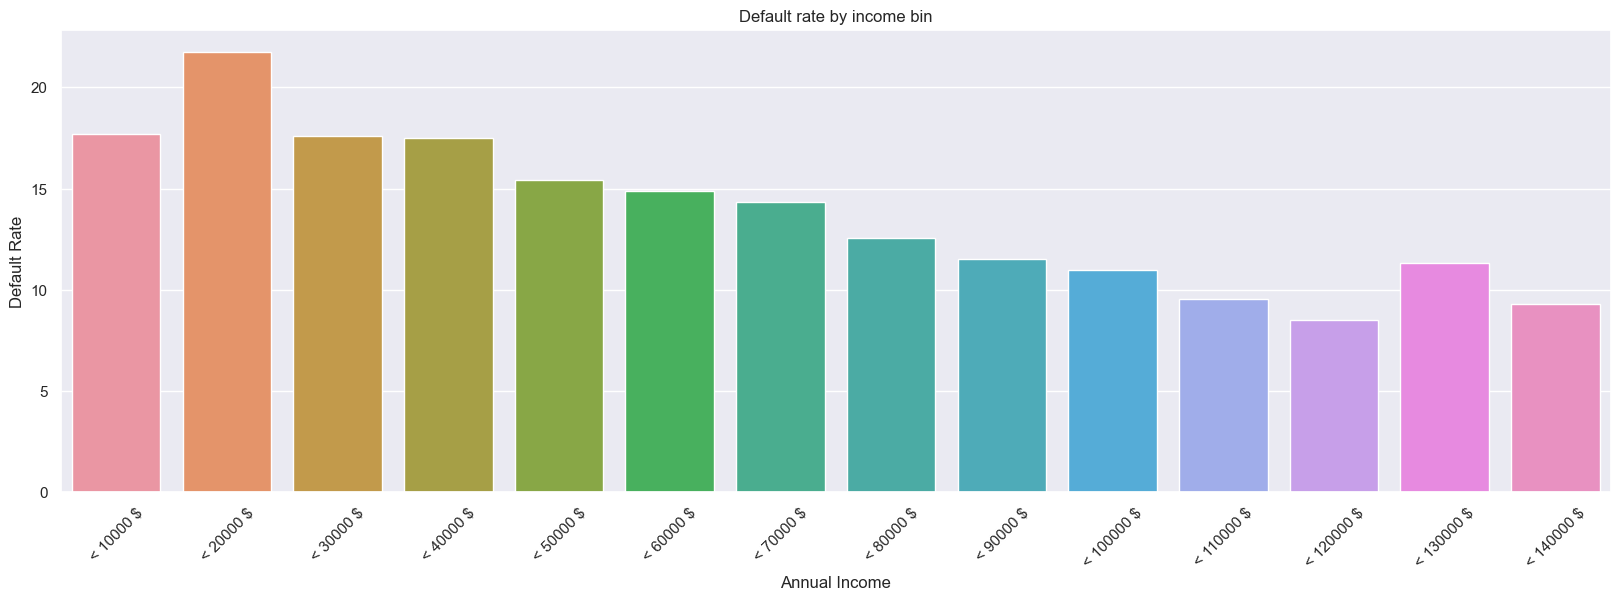

In [20]:
plt.figure(figsize=(20, 6))

# Copy the DataFrame to avoid SettingWithCopyWarning
default_rate_income = loans[['loan_status', 'annual_inc', 'default']].copy()

# Define user-friendly bin edges
bin_edges = range(0, int(default_rate_income['annual_inc'].max() + 10000), 10000)
default_rate_income['income_bin'] = pd.cut(default_rate_income['annual_inc'], bins=bin_edges, include_lowest=True, right=False)

default_rate_income = default_rate_income.groupby(['income_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='income_bin', y='default', data=default_rate_income)
bar_plot.set_xticklabels([f"< {str(interval.right)} $" for interval in default_rate_income['income_bin']], rotation=45)
plt.xlabel('Annual Income')
plt.ylabel('Default Rate')
plt.title('Default rate by income bin')
plt.show()

# Default rate by state

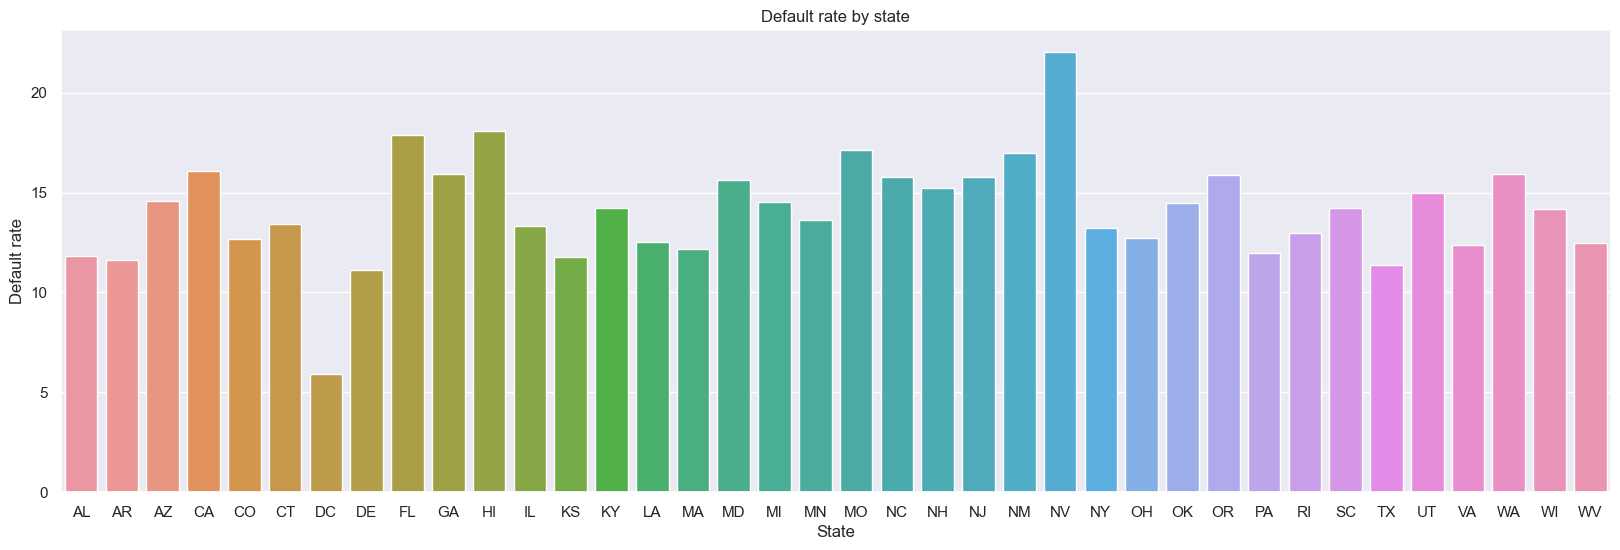

In [21]:
# show the default rate in each state
plt.figure(figsize=(20, 6))
default_rate_state = loans[['addr_state', 'default']].copy()

# ignore states that have less than 100 loans
default_rate_state = default_rate_state.groupby(['addr_state']).filter(lambda x: len(x) > 100)
default_rate_state = default_rate_state.groupby(['addr_state']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='addr_state', y='default', data=default_rate_state)
plt.title('Default rate by state')
plt.xlabel('State')
plt.ylabel('Default rate')
plt.show()

In [22]:
fig = px.choropleth(default_rate_state, locations='addr_state', color='default',
                    locationmode='USA-states', scope="usa",
                    title='Defaulters rate by State',
                    color_continuous_scale=px.colors.sequential.Reds,
                    labels={'percentage': 'Percentage of Defaulters'},
                    )
fig.update_layout(margin={"r": 0, "t": 50, "l": 0, "b": 10})
fig.show()

# Default rate by public records

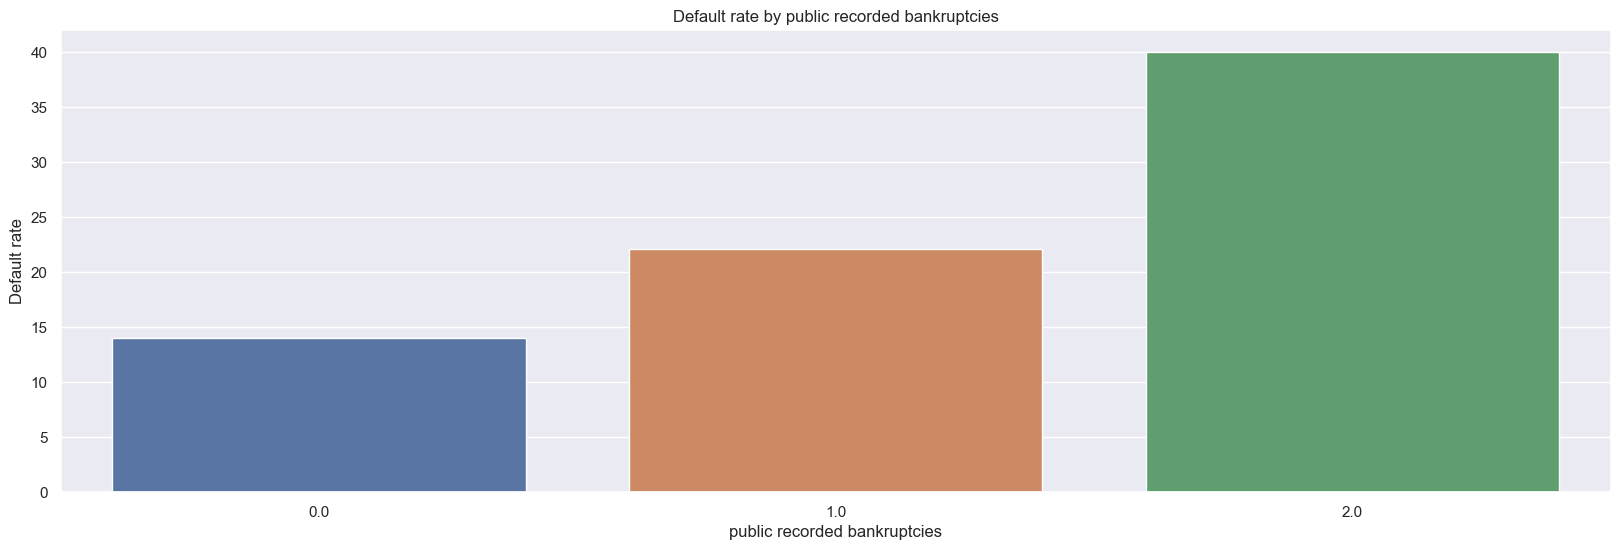

In [23]:
# draw default by pub_rec_bankruptcies
plt.figure(figsize=(20, 6))
default_rate = loans.groupby(['pub_rec_bankruptcies']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='pub_rec_bankruptcies', y='default', data=default_rate)
plt.title('Default rate by public recorded bankruptcies')
plt.xlabel('public recorded bankruptcies')
plt.ylabel('Default rate')
plt.show()


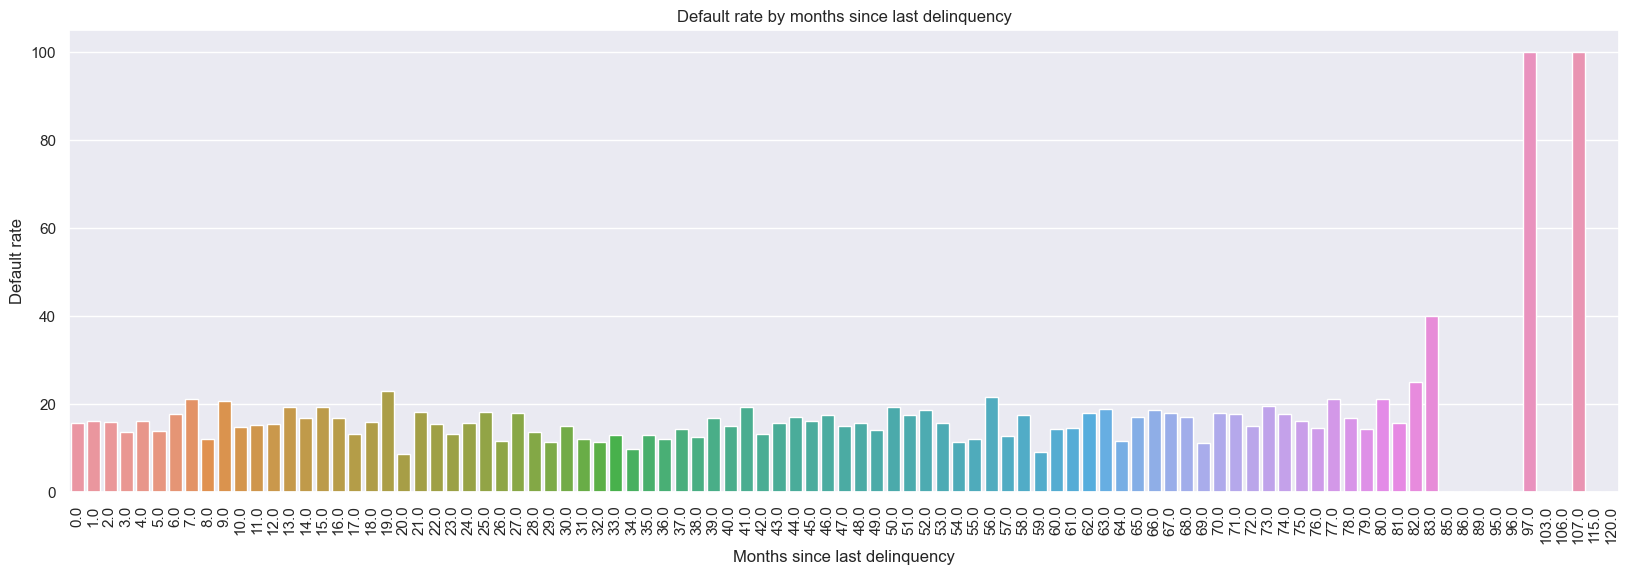

In [24]:
# draw default rate by mths_since_last_delinq (months since last delinquency) after binning
plt.figure(figsize=(20, 6))
default_rate = loans[['mths_since_last_delinq', 'default']].copy()

# bin the values
bin_edges = range(0, int(default_rate['mths_since_last_delinq'].max() + 12), 12)
default_rate['mths_since_last_delinq_bin'] = pd.cut(default_rate['mths_since_last_delinq'], bins=bin_edges, include_lowest=True, right=False)

default_rate = default_rate.groupby(['mths_since_last_delinq']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='mths_since_last_delinq', y='default', data=default_rate)
plt.title('Default rate by months since last delinquency')
plt.xticks(rotation=90)
plt.xlabel('Months since last delinquency')
plt.ylabel('Default rate')
plt.show()

mths_since_last_record
0.0      633
5.0        1
6.0        1
7.0        1
11.0       2
        ... 
117.0     42
118.0     34
119.0      9
120.0      1
129.0      1
Name: count, Length: 110, dtype: int64


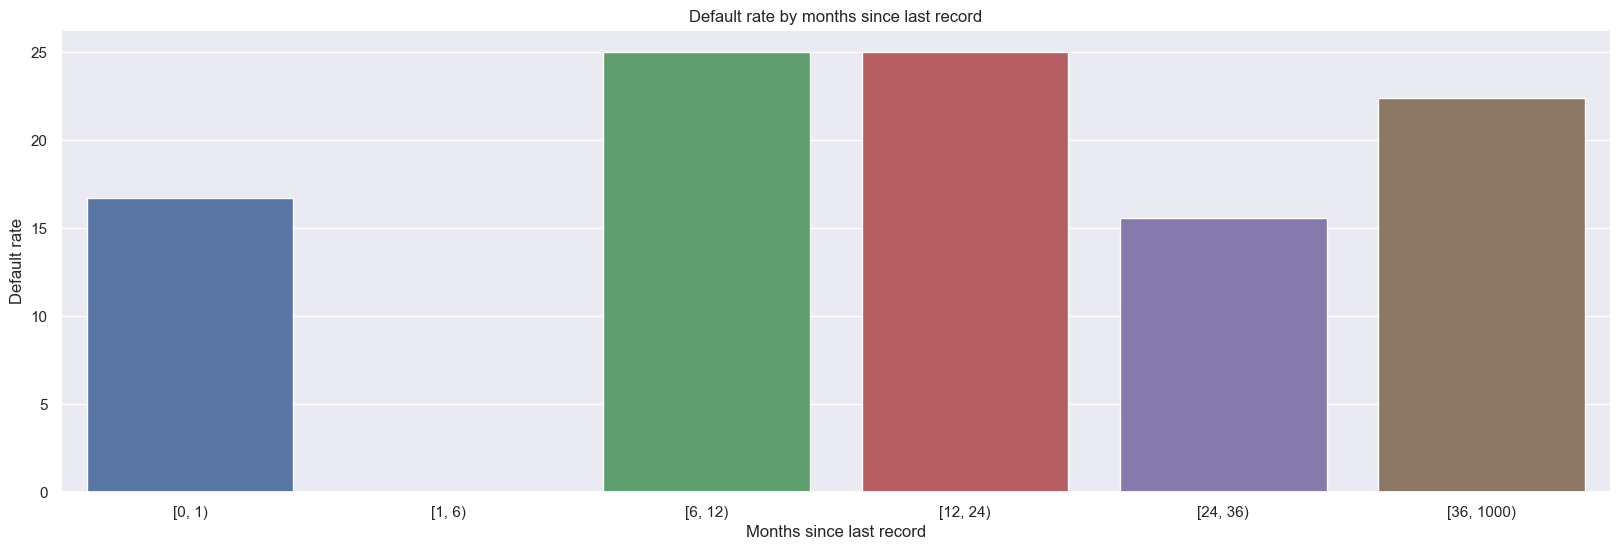

In [25]:
print(loans['mths_since_last_record'].value_counts().sort_index())
# draw default rate by mths_since_last_record (months since last record) after binning
plt.figure(figsize=(20, 6))
default_rate = loans[['mths_since_last_record', 'default']].copy()

# bin mths_since_last_record for 0 months, till last 6 months and more than 6 months
default_rate['mths_since_last_record_bin'] = pd.cut(default_rate['mths_since_last_record'], bins=[0, 1, 6, 12, 24, 36, 1000], include_lowest=True, right=False)

default_rate = default_rate.groupby(['mths_since_last_record_bin']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='mths_since_last_record_bin', y='default', data=default_rate)
plt.title('Default rate by months since last record')
plt.xlabel('Months since last record')
plt.ylabel('Default rate')
plt.show()

# Default rate by interest rate

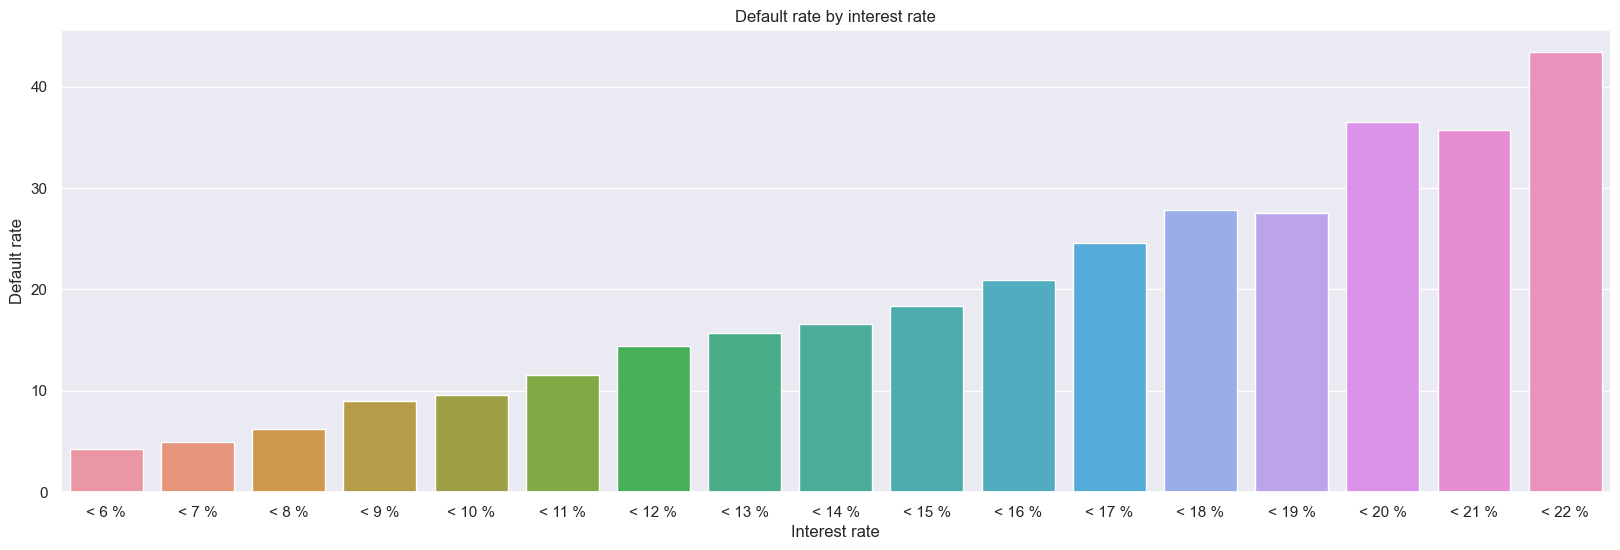

In [26]:
# draw default by binned interest rate
plt.figure(figsize=(20, 6))
default_rate_interest = loans[['int_rate_num', 'default']].copy()
# bin interest rate using intervals of 1% on column 'int_rate_num'
bin_edges = range(int(default_rate_interest['int_rate_num'].min()), int(default_rate_interest['int_rate_num'].max() + 1), 1)
default_rate_interest['int_rate_bin'] = pd.cut(default_rate_interest['int_rate_num'], bins=bin_edges, include_lowest=True, right=False)
default_rate_interest = default_rate_interest.groupby(['int_rate_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='int_rate_bin', y='default', data=default_rate_interest)
plt.title('Default rate by interest rate')
plt.xlabel('Interest rate')
bar_plot.set_xticklabels([f"< {str(interval.right)} %" for interval in default_rate_interest['int_rate_bin']])
plt.ylabel('Default rate')
plt.show()

In [27]:
# show value counts for all categorical columns
for col in loans.select_dtypes(include=['object']).columns:
    print(loans[col].value_counts())

term
 36 months    27469
 60 months     8176
Name: count, dtype: int64
int_rate
10.99%    842
7.51%     764
11.49%    746
7.88%     702
13.49%    681
         ... 
17.90%      1
17.54%      1
18.36%      1
16.01%      1
15.01%      1
Name: count, Length: 357, dtype: int64
grade
B    10903
A     9568
C     7332
D     4692
E     2207
F      764
G      179
Name: count, dtype: int64
sub_grade
A4    2708
B3    2593
A5    2576
B5    2441
B4    2290
C1    1920
B2    1884
C2    1794
A3    1744
B1    1695
A2    1443
C3    1397
D2    1195
C4    1151
A1    1097
C5    1070
D3    1033
D1     877
D4     836
D5     751
E1     610
E2     518
E3     434
E4     356
E5     289
F1     239
F2     193
F3     138
F4     123
F5      71
G1      65
G2      43
G4      28
G3      26
G5      17
Name: count, dtype: int64
emp_title
US Army                                119
Bank of America                        104
AT&T                                    54
US Air Force                            50
Wells Fargo    

In [28]:
print(loans['title'].describe())
df = loans
df['title'] = df['title'].fillna('')
df['title'] = df['title'].astype('str')
# find all rows with credit history in title
def find_credit_history_in_title(row):
    if 'consolidation' in row['title'].lower():
        return row['title']
    else:
        return np.nan

credit_history_in_title  = df.apply(find_credit_history_in_title, axis=1)
credit_history_in_title.value_counts()

count                  35634
unique                 18182
top       Debt Consolidation
freq                    1874
Name: title, dtype: object


Debt Consolidation                          1874
Debt Consolidation Loan                     1428
Consolidation                                435
debt consolidation                           429
Credit Card Consolidation                    332
                                            ... 
John Deer consolidation                        1
Credit Card Consolidation - From College       1
consolidation2011                              1
2 morgage consolidation                        1
MBA Loan Consolidation                         1
Name: count, Length: 1305, dtype: int64